## Calibración de modelos dinámicos



La relación mas conocida que vincula el staff instantaneo en un proyecto de software con el esfuerzo y otros parámetros es el denominado modelo de Putman-Norden-Rayleigh (PNR)



## Calibración de modelos dinámicos

Los modelos dinámicos aplicados a la estimación de proyectos de software incorporan la variación del
esfuerzo en el tiempo.

Para ello estiman el *esfuerzo instantaneo* $E(t)$ también llamado *staff instantaneo* $p(t)$ a partir, típicamente, de una estimación
del esfuerzo total del proyecto $K$ y de una variable relacionada con el tiempo insumido para llegar al máximo de esfuerzo $a$.

La relación para $p(t)$ se extrae del llamado modelo de *Putman-Norden-Rayleigh*

$p(t)=2Kate^{-at^2}$

Donde K es el esfuerzo total del proyecto y a una constante relacionada con la rapidez con la que la función alcanza su valor máximo.

Si el tiempo $t=t_{d}$ es aquel al que se verifica el máximo de la función entonces

$a=\frac{1}{t_{d}^2}$ 

Este parámetro  definirá con que "velocidad" se puede agregar staff al proyecto y por lo tanto la productividad efectiva que se puede alcanzar. 

Dado que la productividad es un parámetro que depende de factores organizacionales, tecnológicos y de proceso puede asumirse que variará lentamente para una misma organización, similar proceso y tecnologías.


Por lo tanto se puede utilizar información histórica *relevante* (en su similitud organizacional, tecnológica y de procesos) para calibrar el factor *a* y con el utilizar el modelo PNR en el planeamiento de un nuevo proyecto futuro.

Una vez disponible la función $p(t)$ es posible obtener la evolución del esfuerzo total en el tiempo con


$E(t)=\int p(t)dt=K(1-e^{-at^2})$

La bibliografía captura, empiricamente, que el proyecto se completa cuando el esfuerzo acumulado verifica la condición

$E(t)=\gamma K$

Donde $0.8 \leq \gamma \geq 0.9$ por lo que despejando puede estimarse el calendario para el fin del proyecto ($t_{f}$) como

$t_{f}=\sqrt {\frac {-\log (1-\gamma)}{a}}$

Dado que la relación entre $p(t)$ y $a$ no es lineal se utilizará un método analítico para resolver posibles valores de $a$ dado el 
esfuerzo máximo nominal involucrado (K)



## Paso 1

Se importan todas las librerías necesarias para realizar la evaluación del modelo PNR

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.optimize import root_scalar
from scipy.integrate import quad
from scipy.optimize import root_scalar




## Paso 2

Define como libreria local todas las funciones que utilizará 

In [2]:
#*--- Estima el esfuero consumido al momento de la liberación del proyecto, el remanente será un residual para soporte post-instalación
def E_proyecto(K,a,gamma):  
   tf=np.sqrt(-np.log(1-gamma)/a)
   Ef=gamma*K
   return tf,Ef

#*--- Calcula el esfuerzo acumulado en función del tiempo E(t)
def E_acum(K,a,t):
    return K*(1-np.exp(-a*(t**2)))

#*--- Calcula el esfuerzo instantaneo o staff p(t) en un momento t
def E(t, K, a):
    """Calcula el valor de la función E(t)"""
    return 2 * K * a * t * np.exp(-a * t**2)

#*--- Encuentra un valor próximo a cero en la asíntota final
def find_near_zero(K, a, tolerance):
    def equation(t):
        return E(t, K, a) - tolerance

    # Encuentra el punto donde y(t) es cercano a la tolerancia usando root_scalar
    result = root_scalar(equation, bracket=[0.1, 100], method='brentq')
    t_near_zero = result.root if result.converged else None
    
    return t_near_zero
#*--- Encuentra el valor máximo de la función p(t)
def find_maximum(K, a):

    # Derivada de la función p(t) con respecto a t
    def negative_E(t):
        return -E(t, K, a)
    
    # Encuentra el máximo usando el método de minimización de la función negativa
    result = minimize_scalar(negative_E, bounds=(0, 100), method='bounded')
    t_max = result.x
    E_max = E(t_max, K, a)
    
    return t_max, E_max

#*--- Calcula un valor corregido de p(t) restando el staff asignado para poder calcular los ceros de la función p(t)-pr 
def y(t, K, a, z):
    """Calcula el valor de la función y(t)."""
    return 2 * K * a * t * np.exp(-a * t**2) - z

#*--- Encuentra ceros en un intervalo dado
def find_zeros(K, a, z):
    zeros = []
    intervals = np.linspace(0, 100, 500)  # Ajusta los límites según el contexto

    for i in range(len(intervals) - 1):
        t1, t2 = intervals[i], intervals[i + 1]
        if y(t1, K, a, z) * y(t2, K, a, z) < 0:  # Verifica cambio de signo
            zero = root_scalar(y, args=(K, a, z), bracket=[t1, t2], method='bisect')
            if zero.converged:
                zeros.append(zero.root)

    return sorted(zeros)

#*--- Calcula el área bajo la curva (integral definida) en el intervalo [t1,t2]
def area_under_curve(t1, t2, K, a, z):
    integral, _ = quad(lambda t: max(y(t, K, a, z), 0), t1, t2)
    return integral

#*--- encuentra ceros de la función
def encuentra_restriccion(K,a,pr):
    ceros = find_zeros(K, a, pr)

# Calcula el área bajo la curva para y(t) >= 0
    if len(ceros) >= 2:
       t1, t2 = ceros[0], ceros[-1]  # Considera los ceros extremos
       E2 = area_under_curve(t1, t2, K, a, pr)
       #print(f"El Área bajo la curva donde p(t)-pr >= 0: E2={E2:.2f} PM quedará sin satisfacción")
    else:
       print("No se encontraron suficientes ceros para calcular el área.")
       sys.exit()
    return ceros[0],ceros[-1]

#*--- Calcula intervalo del proyecto que opera bajo restricción de recursos
def calcula_restriccion(K,a,pr,t1,t2):
    Er=E_acum(K,a,t2)-E_acum(K,a,t1)
    E3=pr*(t2-t1)
    E2=Er-E3
    return Er,E2,E3

#*--- Calcula el tiempo que debe asignar un staff fijo pr para acumular un esfuerzo E
def esfuerzo_fijo(E,pr):
    return E/pr

#*--- Calcula el valor medio de la función en el intervalo [0,tx]
def average_value(K, a, tx):
    integral, _ = quad(E, 0, tx, args=(K, a))
    average = integral / tx
    return average

#*=*=*=*=*=*=*=* Funciones auxiliares de graficación

#*--- Calcula el esfuerzo instantaneo sobre un vector numpy t
def esfuerzo_instantaneo(t, a):
    return 2 * K * a * t * np.exp(-a * t**2)

#*--- Calcula el esfuerzo constante sobre un vector numpy t
def esfuerzo_constante(t,pr):
    l=len(t)
    return np.full(l,pr) 

#*--- Calcula el esfuerzo acumulado sobre un vector numpy t
def esfuerzo_acumulado(t,a):
    return K*(1-np.exp(-a * t**2))


## Paso 3

Se define el dataset a utilizar como información histórica que se utilizará para calibrar el modelo,
debe cuidarse que el número de elementos sea el mismo para ambos vectores utilizados.

Se calcula el esfuerzo total (K) del proyecto como la suma de los esfuerzos contenidos en el dataset.

Calcula a partir del dataset {$E_1$,...$E_n$} el esfuerzo total nominal del proyecto (K) como 

$K=\sum_{i=1}^n E_i$



In [3]:
t_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])        # Tiempo en meses
E_data = np.array([8, 21, 25, 30, 25, 24, 17, 15, 11, 6])  # Esfuerzo instantáneo en persona-mes
df = pd.DataFrame(E_data,t_data)
print(df)
K = np.sum(E_data)
print("El esfuerzo total del proyecto es K=%d PM" % (K))

     0
1    8
2   21
3   25
4   30
5   25
6   24
7   17
8   15
9   11
10   6
El esfuerzo total del proyecto es K=182 PM


## Paso 4

Obtiene un valor estimado del parámetro "$a$" para a utilizando una técnica de "curve fit"

In [4]:
popt, pcov = curve_fit(esfuerzo_instantaneo, t_data, E_data, p0=[0.1])
a_estimada = popt[0]
print(f"Parámetro a estimado: {a_estimada:.3f}")


Parámetro a estimado: 0.030


## Paso 5

Calcula el valor modelado de la función $E(t)$ y lo grafica junto con los valores del dataset histórico utilizado para la calibración


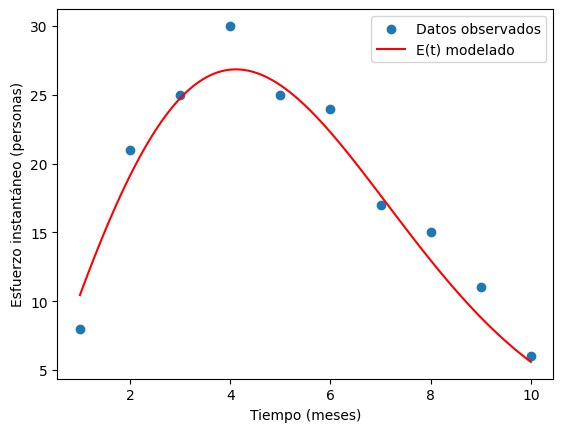

In [5]:
t_fit = np.linspace(min(t_data), max(t_data), 100)
E_fit = esfuerzo_instantaneo(t_fit, a_estimada)

plt.scatter(t_data, E_data, label='Datos observados')
plt.plot(t_fit, E_fit, label='E(t) modelado', color='red')

plt.xlabel('Tiempo (meses)')
plt.ylabel('Esfuerzo instantáneo (personas)')
plt.legend()
plt.show()

## Paso 6 Caso I Modelo de proyecto sin restricciones de recursos


Dado un nuevo proyecto se indica el esfuerzo $K_{nominal}$ para estimar el perfil de recursos utilizando el modelo recientemente calibrado

In [6]:
name='hypernimbus'
K=212    #Esfuerzo total expresado en PM


Se analiza como resulta el proyecto comparado con los datos históricos de calibración, debido a los límites de validez de la calibración
los valores del proyecto bajo análisis no deben diferir significativamente de los utilizados en el dataset de calibración

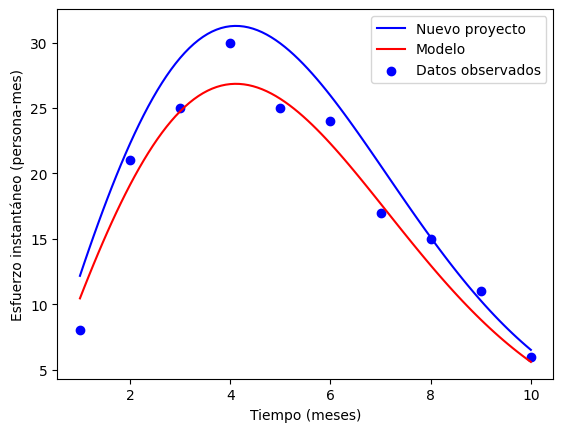

In [7]:
t_fit = np.linspace(min(t_data), max(t_data), 100)
O_fit = esfuerzo_instantaneo(t_fit, a_estimada)

plt.plot(t_fit, O_fit, label='Nuevo proyecto', color='blue')
plt.plot(t_fit, E_fit, label='Modelo', color='red')

plt.scatter(t_data, E_data, label='Datos observados', color='blue')

#plt.plot(t_fit, E_fit, label='Modelo calibrado (best fit)', color='red')

plt.xlabel('Tiempo (meses)')
plt.ylabel('Esfuerzo instantáneo (persona-mes)')
plt.legend()
plt.show()

## Paso 7

Obtener una estimación del esfuerzo acumulado $E(t)$ durante el proyecto

$E(t)=K(1-e^{-at^2})$

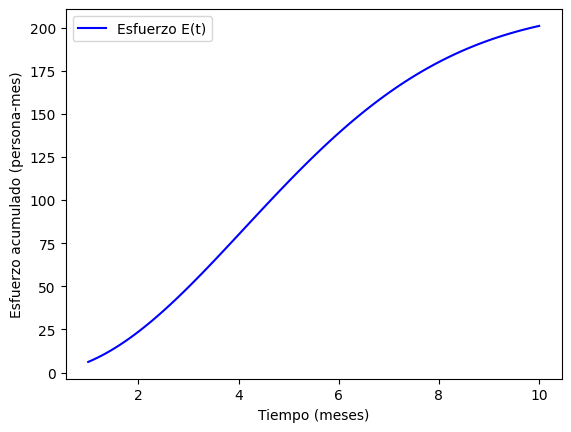

In [8]:

O_fit = esfuerzo_acumulado(t_fit, a_estimada)
t_fit = np.linspace(min(t_data), max(t_data), 100)

plt.plot(t_fit, O_fit, label='Esfuerzo E(t)', color='blue')
plt.xlabel('Tiempo (meses)')
plt.ylabel('Esfuerzo acumulado (persona-mes)')
plt.legend()
plt.show()

## Paso 9

Se completa el análisis del proyecto bajo estudio calculando el tiempo de finalización nominal ($t_{f}$)  del proyecto asumiendo que la proporción de consumo de recursos al momento  de la entrega será $\gamma = 0.9$

$t_{f}=\sqrt {\frac {-\log (1-\gamma)}{a}}$

Siendo

E($t_{f}$) = $\gamma K$

Luego de la finalización nominal los recursos se reducirán asintóticamente a cero pero sin llegar a serlo,
la función del esfuerzo instantaneo:

$p(t)=2Kate^{-at^2}=0$


Siendo $K$ y $a$ constantes conocidas la única forma que ésta ecuacion sea igual a cero es si
el término $t=0$ ya que el término $e^{-at^2} nunca es cero para $t>0$
Sin embargo, si el objetivo es encontrar $t>0$ donde $p(t)$ se vuelve cero analizar las características del problema más allá de la ecuación misma.
Podemos en cambio analizar qué sucede cuando la función es cercana a cero o encontrar el punto en el que 
p(t) se vuelve muy pequeño siendo  útil para el análisis un resultado aproximado

El esfuerzo residual $E_{nz}$ se insumirá entre el plazo de entrega $t_{f}$ y la extinción del proyecto.

Se calcula el valor medio del staff $\bar{p}$ en el intervalo [0,$t_{f}$]


$\bar{p} = \frac{1}{t_f} \int_{0}^{t_f} 2 \cdot K \cdot a \cdot t \cdot e^{-at^2} \, dt$





In [9]:
gamma=0.9
tf,Ef = E_proyecto (K,a_estimada,gamma)

print("Solución de planeamiento sin restricciones proyecto %s" % (name))
print("\t")
print("\tEsfuerzo nominal            (K)=%.1f PM" % (K))
print("\tTiempo para entrega        (tf)=%.1f meses" % (tf))
print("\tEsfuerzo acumulado@tf   (E(tf))=%.1f PM" % (Ef)) 

# Encuentra el tiempo t y el valor máximo de E(t)
tmax, pmax = find_maximum(K, a_estimada)

print("\t ")
print("\tMaxima alocación       (tmax)=%.1f meses" % (tmax))
print("\tMaxima staff asignado  (pmax)=%.1f personas" % (pmax))

# Encuentra el valor de t donde E(t) es cercano a cero
t_near_zero = find_near_zero(K, a_estimada,1)
if t_near_zero is None:
    print("No se encontró un valor de t donde y(t) sea cercano a cero.")
    sys.exit()
Enz=E_acum(K,a_estimada,t_near_zero)-E_acum(K,a_estimada,tf)

print("\t")
print("\tTiempo residual         (tnz)=%.1f meses" % (t_near_zero))
print("\tEsfuerzo residual       (Enz)=%.1f PM" % (Enz))

# Calcula el valor medio de la función en el intervalo [0, tx]
pmed = average_value(K, a_estimada, tf)
prel = E(tf,K,a_estimada)
print("\t")
print("\tStaff promedio [0,%.1f]   (pmed)=%.1f personas" % (tf,pmed))
print("\tStaff al release         (prel)=%.1f personas" % (prel))



Solución de planeamiento sin restricciones proyecto hypernimbus
	
	Esfuerzo nominal            (K)=212.0 PM
	Tiempo para entrega        (tf)=8.8 meses
	Esfuerzo acumulado@tf   (E(tf))=190.8 PM
	 
	Maxima alocación       (tmax)=4.1 meses
	Maxima staff asignado  (pmax)=31.3 personas
	
	Tiempo residual         (tnz)=13.1 meses
	Esfuerzo residual       (Enz)=19.9 PM
	
	Staff promedio [0,8.8]   (pmed)=21.6 personas
	Staff al release         (prel)=11.1 personas


## Paso 11

Si el proyecto se debe realizar bajo restricción de recursos se analizará como se altera su planeamiento para el caso
$p_{r} < p_{max}$ asumiendo que el esfuerzo total del proyecto no se altera, seguramente deberá gestionarse una contingencia
como riesgo para el caso que restricción reduzca la eficiencia de operación y se produzca mayor consumo de recursos

Se empieza por definir el número máximo de recursos disponible pr
Se sugiere asignar recursos tal que $p_{r}>p_{release}$ y $p_{r}<=\bar{p}$


In [10]:
pr=6  # Máxima asignación de recursos

## Paso 12

Calcula los momentos en el tiempo donde la asignación sin restricciones del proyecto supera a la restricción impuesta por los recursos insuficientes
para sostener la condición de máximo de staff asignado del caso sin restricción.

Se denomina a éstos momentos $t_{1}$ y $t_{2}$ (tiempos de restricción)

Los valores bajo planeamiento con restricciones serán:

$E_{1}$ Esfuerzo transcurrido en el proyecto antes de ingresar en zona de restricción en $t_{1}$

$E_{r}$ El esfuerzo total del proyecto si no tuviera restricciones en el intervalo [ $t_{1}$ , $t_{2}$  ]

$E_{2}$ El esfuerzo que no es posible satisfacer debido a la restricción en el intervalo [ $t_{1}$ , $t_{2}$  ]

$E_{3}$ El esfuerzo que se puede resolver con los recursos disponibles en el intervalo [ $t_{1}$ , $t_{2}$  ]

$E_{4}$ El esfuerzo que transcurre desde que termina la restricción en $t_{2}$ y la finalización del proyecto en $t_{f}$


Del total de esfuerzo con solución pendiente por falta de recursos se acumula esfuerzo
adicional  manteniendo una asignación restringida constante de $p_{r}$ personas durante 
un tiempo adicional $\Delta t$ a partir de $t_{2}$ hasta completar el total del esfuerzo en restricción $E_{3}$

In [11]:

if pr<prel:
    print("** Error ** Los recursos deben ser superiores a %.1f personas" % (prel))
    pr=round(prel+0.5)
    print("Se ajusta recursos mínimos a pr=%.1f" % (pr))

t1,t2 = encuentra_restriccion(K,a_estimada,pr)

if t2>tf:
    print("La restricción dura mas que el proyecto, incrementar recursos")
    exit


Er,E2,E3 = calcula_restriccion(K,a_estimada,pr,t1,t2)
E1=E_acum(K,a_estimada,t1)
E4=E_acum(K,a_estimada,tf)-E_acum(K,a_estimada,t2)

print("Solución de planeamiento con restricciones proyecto %s" % (name))
print("\t")
print("\tEsfuerzo nominal            (K)=%.1f PM" % (K))
print("\tTiempo para entrega        (tf)=%.1f meses" % (tf))
print("\t")
print("\tLa restriccion ocurre en el intervalo [%.1f,%.1f] meses" % (t1,t2))


print("\t\tEsfuerzo intervalo [0,%.1f] meses hasta restricción E1=%.1f PM" % (t1,E1))
print("\t\tEl total del esfuerzo en intervalo de restricción [%.1f,%.1f] Er=%.2f PM" % (t1,t2,Er))
print("\t\t\tEsfuerzo posible con recursos disponibles E3=%.2f PM" % (E3))
print("\t\t\tEsfuerzo pediente sin solución            E2=%.2f PM" % (E2))
print("\t\tEl esfuerzo en el intervalo [%.1f,%.1f]  despues de la restricción E4=%.1f PM" % (t2,tf,E4))
print("\t")
print("\tEl esfuerzo total en condiciones de restricción es Etot=E1+E2+E3+E4=%.1f PM" % (E1+E2+E3+E4))

tx=esfuerzo_fijo(E2,pr)

print("\t")
print("\tTiempo agregado a partir de [%.1f,%.1f] a recursos constantes %.2f meses por un total Ex=%.2f PM" % (t1,t2,tx,pr*tx))
print("\tLa duración total del proyecto será ahora")
print("\t\tEtapa sin restricción [0,%.1f]  (%.1f meses)" % (t1,t1))
print("\t\tEtapa con restricción [%.1f,%.1f] (%.1f meses)" % (t1,t2,t2-t1))
print("\t\tEtapa adicional para compensar restricción [%.1f,%.1f] (%.1f meses)" % (t2,t2+tx,tx))
print("\t\tFinalización del proyecto [%.1f,%.1f] (%.1f meses)" % (t2+tx,tf+tx,tf+tx-t2-tx))
print("\t")
print("\tDuración total del proyecto con restriccion de recursos (pr=%.1f)=%.1f meses" % (pr,tf+tx))



** Error ** Los recursos deben ser superiores a 11.1 personas
Se ajusta recursos mínimos a pr=12.0
Solución de planeamiento con restricciones proyecto hypernimbus
	
	Esfuerzo nominal            (K)=212.0 PM
	Tiempo para entrega        (tf)=8.8 meses
	
	La restriccion ocurre en el intervalo [1.0,8.6] meses
		Esfuerzo intervalo [0,1.0] meses hasta restricción E1=6.0 PM
		El total del esfuerzo en intervalo de restricción [1.0,8.6] Er=182.47 PM
			Esfuerzo posible con recursos disponibles E3=91.64 PM
			Esfuerzo pediente sin solución            E2=90.83 PM
		El esfuerzo en el intervalo [8.6,8.8]  despues de la restricción E4=2.3 PM
	
	El esfuerzo total en condiciones de restricción es Etot=E1+E2+E3+E4=190.8 PM
	
	Tiempo agregado a partir de [1.0,8.6] a recursos constantes 7.57 meses por un total Ex=90.83 PM
	La duración total del proyecto será ahora
		Etapa sin restricción [0,1.0]  (1.0 meses)
		Etapa con restricción [1.0,8.6] (7.6 meses)
		Etapa adicional para compensar restricción [8.6,1

## Final

Gráficamente las distintas etapas del proyecto a ejecutar bajo restricciones será

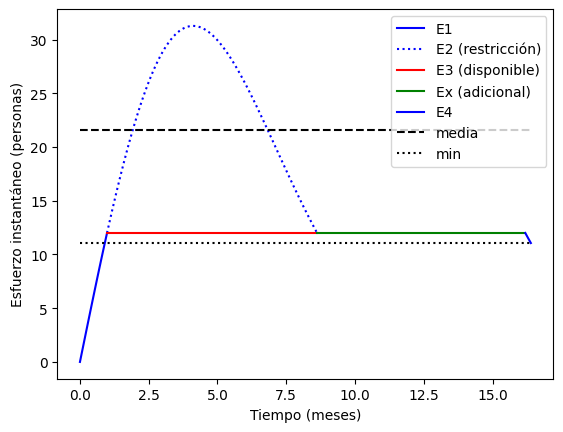

In [12]:

t_E1=np.linspace(0,t1,100)
t_E1_fit = esfuerzo_instantaneo(t_E1, a_estimada)

t_E2=np.linspace(t1,t2,100)
t_E2_fit=esfuerzo_instantaneo(t_E2, a_estimada)
t_E3_fit=esfuerzo_constante(t_E2,pr)

t_Ex = np.linspace(t2,t2+tx,100)
t_Ex_fit=esfuerzo_constante(t_Ex,pr)

t_E4=np.linspace(t2+tx,tf+tx,100)
t_tail=np.linspace(t2,tf,100)
t_E4_fit = esfuerzo_instantaneo(t_tail, a_estimada)

t_med = np.linspace(0,tf+tx,100)
t_med_fit=esfuerzo_constante(t_med,pmed)

t_min = np.linspace(0,tf+tx,100)
t_min_fit=esfuerzo_constante(t_min,prel)


plt.plot(t_E1, t_E1_fit, label='E1', color='blue')
plt.plot(t_E2, t_E2_fit, label='E2 (restricción)', linestyle=":",color='blue')
plt.plot(t_E2, t_E3_fit, label='E3 (disponible)',color='red')
plt.plot(t_Ex, t_Ex_fit, label='Ex (adicional)',color='green')
plt.plot(t_E4, t_E4_fit, label='E4', color='blue')


plt.plot(t_med, t_med_fit, label='media', linestyle="--",color='black')
plt.plot(t_min, t_min_fit, label='min', linestyle=":",color='black')


plt.xlabel('Tiempo (meses)')
plt.ylabel('Esfuerzo instantáneo (personas)')
plt.legend()
plt.show()

## Analisis de comportamientos acelerados

Cuando se desea reducir el plazo de entrega $t_{f}$ implica asumir una productividad mas alta que la sugerida por el modelo, lo que implica mas alta que la sugerida por la historia utilizada para calibrar el modelo.

En principio, se pueden encontrar soluciones analíticas para cualquier reducción arbitraria de $t_{f}$ , pero
conseguir obtener en la práctica productividades que lo validen es otra cuestión.

Boehm caracterizó la zona imposible como los incrementos de esfuerzo necesarios para obtener reducciones de
mas de 30% en el calendario de entrega.

Si $E(t)=K(1-e^{-at^2})$

Si se desea alcanzar un fin de proyecto mas temprano en una proporción $\Gamma$

$t^\prime_{f} = \Gamma t_{f}$

Entonces el factor $a^\prime$ que es necesario alcanzar será

$a^\prime=-\frac{\log(0.1)}{(t^\prime_{f} \Gamma)^2}$

Se considera que para $\Gamma \leq 0.7$ el proyecto se intenta ejecutar en zona imposible y los valores de $a$ necesarios no son alcanzables.


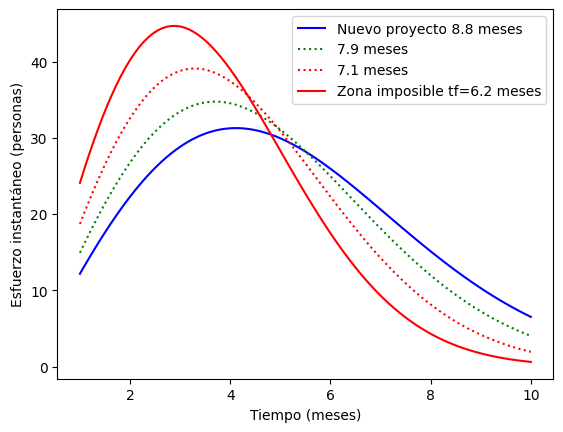

In [42]:
rho=np.array([1.0,0.9,0.8,0.7])
tfp=rho*tf
ap=-np.log(0.1)/(tfp**2)

t_fit = np.linspace(min(t_data), max(t_data), 100)
O_fit = esfuerzo_instantaneo(t_fit, a_estimada)

a1_fit=esfuerzo_instantaneo(t_fit, ap[1])
a2_fit=esfuerzo_instantaneo(t_fit, ap[2])
a3_fit=esfuerzo_instantaneo(t_fit, ap[3])

r100_label="Nuevo proyecto %.1f meses" % (tfp[0])
r90_label="%.1f meses" % (tfp[1]) 
r80_label="%.1f meses" % (tfp[2]) 
iz_label="Zona imposible tf=%.1f meses" % (tfp[3]) 

plt.plot(t_fit, O_fit, label=r100_label, color='blue')
plt.plot(t_fit, a1_fit, label=r90_label, linestyle=":", color='green')
plt.plot(t_fit, a2_fit, label=r80_label,linestyle=":",color='red')
plt.plot(t_fit, a3_fit, label=iz_label,color='red')

plt.xlabel('Tiempo (meses)')
plt.ylabel('Esfuerzo instantáneo (personas)')
plt.legend()
plt.show()

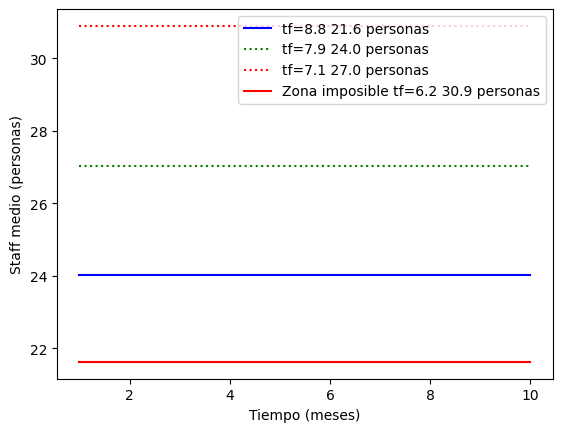

In [49]:
pmed1 = average_value(K, ap[1], tfp[1])
pmed2 = average_value(K, ap[2], tfp[2])
pmed3 = average_value(K, ap[3], tfp[3])

t_med_fit=esfuerzo_constante(t_fit,pmed)
t_med1_fit=esfuerzo_constante(t_fit,pmed1)
t_med2_fit=esfuerzo_constante(t_fit,pmed2)
t_med3_fit=esfuerzo_constante(t_fit,pmed3)

r100_label="tf=%.1f %.1f personas" % (tf,pmed)
r90_label="tf=%.1f %.1f personas" % (tfp[1],pmed1)
r80_label="tf=%.1f %.1f personas" % (tfp[2],pmed2)
iz_label="Zona imposible tf=%.1f %.1f personas" % (tfp[3],pmed3)


plt.plot(t_fit,t_med1_fit,label=r100_label,color='blue')
plt.plot(t_fit,t_med2_fit,linestyle=":",label=r90_label,color='green')
plt.plot(t_fit,t_med3_fit,linestyle=":",label=r80_label,color='red')
plt.plot(t_fit, t_med_fit,label=iz_label,color='red')

plt.xlabel('Tiempo (meses)')
plt.ylabel('Staff medio (personas)')
plt.legend()
plt.show()

